## Preliminaries

In [1]:
!pip install openpyxl==3.0.0

     |████████████████████████████████| 172 kB 5.4 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241207 sha256=57e220988f80e734fd69d4c37b19f9c6a7d3bd71911965f3cadad095a08c0ff3
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 3.0.9
    Uninstalling openpyxl-3.0.9:
      Successfully uninstalled openpyxl-3.0.9


## Libraries

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import glob
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.graph_objects as go
import networkx as nx

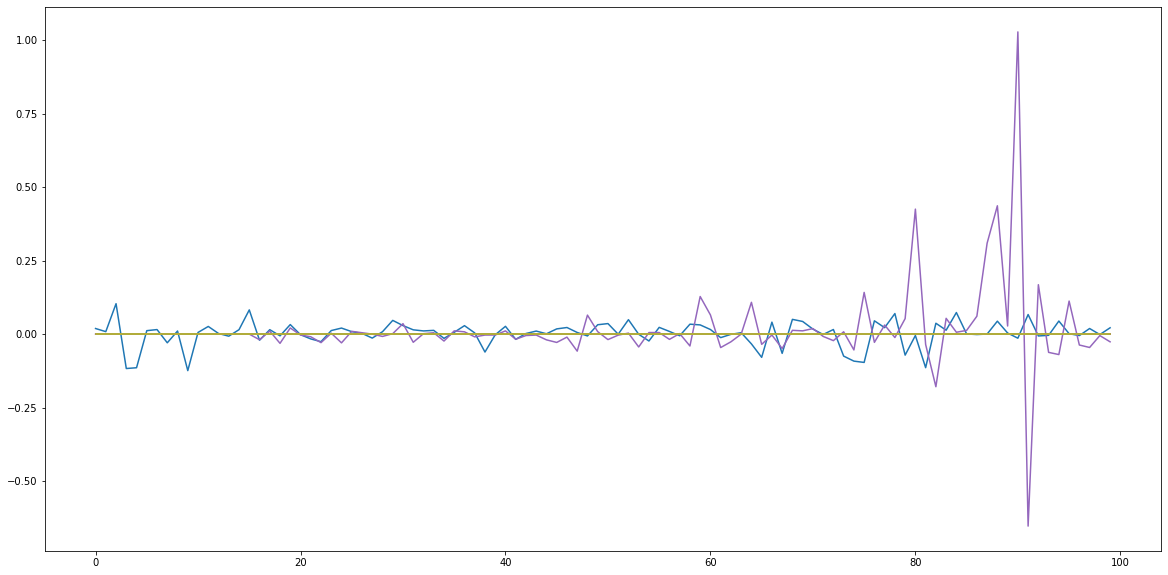

In [ ]:
# data = pd.read_excel('/content/drive/Shareddrives/BTP/CombinedFiles/returns.xlsx')
plt.figure(figsize=[20,10])
for col in data.columns[1:10]:
  plt.plot(data[col][:100])


## Generate closing price file

In [ ]:
def get_dataframe(columnName, cryptoDataFolderPath, dates_arr):
  df = pd.DataFrame()
  for file in glob.glob(cryptoDataFolderPath + '*.xlsx'):
    tic = file.split('/')[-1].split('.')[0]
    df_temp = pd.read_excel(file)
    req_column = []
    
    for idx in range(len(dates_arr)):
      if dates_arr[idx] in list(df_temp['Date']):
        i = list(df_temp['Date']).index(dates_arr[idx])
        req_column.append(df_temp[columnName][i])
      else:
        req_column.append(-1)
    df[tic] = req_column
  return df
    

In [ ]:
dates_arr = list(pd.read_excel('/content/drive/Shareddrives/BTP/CryptoData/BTC.xlsx')['Date'])
data = get_dataframe('C','/content/drive/Shareddrives/BTP/CryptoData/', dates_arr)
data['Date'] = dates_arr
data.to_excel('/content/drive/Shareddrives/BTP/CombinedFiles/closing_price.xlsx')

## Calculate returns

In [ ]:
data = pd.read_excel('/content/drive/Shareddrives/BTP/CombinedFiles/closing_price_after_interpolation.xlsx')
dates_arr = data['Date']

In [ ]:
data.columns

Index(['Unnamed: 0', 'BTC', 'BNB', 'ADA', 'SOL', 'XRP', 'LUNA', 'DOT', 'DOGE',
       'AVAX',
       ...
       'REN', 'DGB', 'BTRST', 'TRIBE', 'SRM', 'UOS', 'ZRX', 'CRO', 'BSV',
       'Date'],
      dtype='object', length=102)

In [ ]:
temp = [[np.nan, 1],[2,3]]
np.corrcoef(temp)

array([[nan, nan],
       [nan,  1.]])

In [ ]:
data2 = pd.DataFrame()
for col in data.columns[1:-1]:
  req_column = []
  for i in range(1,len(data[col])):
    if data[col][i-1] and data[col][i]:
      req_column.append(np.log(data[col][i])-np.log(data[col][i-1]))      
    else:
      req_column.append(np.nan)
  data2[col] = req_column


In [ ]:
data2

,BTC,BNB,ADA,SOL,XRP,LUNA,DOT,DOGE,AVAX,MATIC,SHIB,WBTC,ATOM,LTC,LINK,NEAR,UNI,TRX,ALGO,FTT,BCH,FTM,XLM,ETH,MANA,ICP,ETC,VET,XTZ,FIL,EGLD,AXS,THETA,XMR,EOS,MKR,AAVE,BTT,GRT,STX,...,1INCH,HOT,XDC,IOTX,OMG,QTUM,ANKR,BNT,SNX,CEL,CHSB,ZIL,GNO,LPT,RLY,ICX,BTG,SPELL,SC,SUSHI,ZEN,IOST,ONT,STORJ,JST,POLY,UMA,SKL,KNC,OCEAN,NU,REN,DGB,BTRST,TRIBE,SRM,UOS,ZRX,CRO,BSV
0,0.019102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.022934,NaN,NaN,0.024824,NaN,NaN,NaN,NaN,NaN,NaN,0.190488,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.008412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.134873,NaN,NaN,0.031085,NaN,NaN,NaN,NaN,NaN,NaN,-0.051484,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.103527,NaN,NaN,NaN,0.010272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.151615,NaN,NaN,0.152447,NaN,NaN,NaN,NaN,NaN,NaN,0.140795,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.117020,NaN,NaN,NaN,0.010167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.091674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.078389,NaN,NaN,-0.075074,NaN,NaN,NaN,NaN,NaN,NaN,-0.125394,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-0.114328,NaN,NaN,NaN,0.010065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.093248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.017459,NaN,NaN,-0.061225,NaN,NaN,NaN,NaN,NaN,NaN,-0.136317,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,0.014767,0.0,0.005547,0.019901,0.003245,-0.073636,0.011516,-0.001765,0.035363,0.052111,0.000000,0.015579,-0.016807,0.023752,0.059272,0.026992,0.033071,0.020375,0.023848,0.046687,0.024521,0.022140,0.023568,0.048610,0.013228,0.035074,0.033426,0.027219,0.037104,0.021628,0.014705,-0.008250,0.016005,0.029047,0.035874,0.055927,0.031195,-6.933441,0.021233,0.041964,...,0.036132,0.0,0.001624,-0.008766,0.081078,0.040706,0.005704,0.042560,0.000000,0.125959,0.028264,0.028448,0.043725,0.061834,0.018391,0.025812,0.059186,0.024053,0.048691,0.025392,0.060785,0.0,0.0,0.046549,0.016333,0.041656,0.058236,0.048494,-0.006283,0.070480,0.059594,0.066291,0.003438,0.106543,0.011095,0.033339,0.047347,0.025424,0.049170,0.014021
1853,0.011840,0.0,0.011096,0.052251,0.009689,0.009865,0.022109,0.010545,0.070384,0.013587,0.018605,0.011897,-0.013652,0.012254,0.003893,0.025559,0.045181,0.046527,0.010683,0.040521,0.007284,-0.011366,0.024097,0.022095,0.038243,-0.006421,0.007248,0.012247,0.024983,0.032625,0.037987,0.051739,0.012837,0.030570,0.012903,0.041806,0.032461,0.219433,-0.008975,0.033673,...,0.042459,0.0,-0.012246,0.032058,0.062181,0.028064,0.009252,0.012423,0.166886,0.035121,0.060872,0.001896,0.026037,0.046116,0.024748,0.050245,0.020966,0.278960,0.004938,0.006374,0.065500,0.0,0.0,0.022981,0.029195,0.011113,0.011580,0.012600,-0.036694,0.018115,0.066651,0.043920,-0.001374,-0.080264,-0.003345,0.026684,0.003149,0.038540,0.027643,0.023750
1854,-0.007519,0.0,-0.023281,-0.031022,-0.025373,-0.093898,-0.030322,-0.025497,-0.056611,-0.05611

In [ ]:
data2.to_excel('/content/drive/Shareddrives/BTP/CombinedFiles/returns_after_interpolation.xlsx',index=False)

## Data handling

In [ ]:
# data = pd.read_excel('/content/drive/Shareddrives/BTP/CombinedFiles/closing_price.xlsx')
data.replace(to_replace=float(-1), value= np.nan, inplace=True)
data.head()

,Unnamed: 0,BTC,BNB,ADA,SOL,XRP,LUNA,DOT,DOGE,AVAX,MATIC,SHIB,WBTC,ATOM,LTC,LINK,NEAR,UNI,TRX,ALGO,FTT,BCH,FTM,XLM,ETH,MANA,ICP,ETC,VET,XTZ,FIL,EGLD,AXS,THETA,XMR,EOS,MKR,AAVE,BTT,GRT,...,HOT,XDC,IOTX,OMG,QTUM,ANKR,BNT,SNX,CEL,CHSB,ZIL,GNO,LPT,RLY,ICX,BTG,SPELL,SC,SUSHI,ZEN,IOST,ONT,STORJ,JST,POLY,UMA,SKL,KNC,OCEAN,NU,REN,DGB,BTRST,TRIBE,SRM,UOS,ZRX,CRO,BSV,Date
0,0.0,992.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.19000,NaN,NaN,1.3965,NaN,NaN,NaN,NaN,NaN,NaN,13.88200,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-01 00:00
1,1.0,1012.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.38000,NaN,NaN,1.4316,NaN,NaN,NaN,NaN,NaN,NaN,16.79499,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-02 00:00
2,2.0,1020.67,NaN,NaN,NaN,0.00678,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.59000,NaN,NaN,1.4768,NaN,NaN,NaN,NaN,NaN,NaN,15.95220,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-03 00:00
3,3.0,1132.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.6200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.16000,NaN,NaN,1.7200,NaN,NaN,NaN,NaN,NaN,NaN,18.36400,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-04 00:00
4,4.0,1006.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.2153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.31859,NaN,NaN,1.5956,NaN,NaN,NaN,NaN,NaN,NaN,16.19979,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-05 00:00


In [ ]:
# to interpolate the missing values
data.interpolate(method ='linear', limit_direction ='forward', inplace=True)
data.to_excel('/content/drive/Shareddrives/BTP/CombinedFiles/closing_price_after_interpolation.xlsx', index=False)

## Generate EdgeList

In [6]:
def get_adjacency_matrix(corrMatrix, n, threshold=0.3):
  adj_matrix = [[0 for _ in range(n)] for _ in range(n)]
  # print(corr_matrix)
  for i in range(n):
    for j in range(n):
      
      if i!=j and np.abs(corrMatrix[i][j])>threshold:
        adj_matrix[i][j] = corrMatrix[i][j]
  
  return nx.from_numpy_matrix(np.matrix(adj_matrix))

In [4]:
# assumption: data of all coins present at the start date is taken for 'timespan' duration
# timespan in num of days
def get_interval_data(start_idx, timespan, data):
  col_list = []
  for cols in data.columns:
    if pd.notnull(data[cols][start_idx]):
      # print(cols)
      col_list.append(cols)
  
  df = data[col_list][start_idx:start_idx+timespan].copy().reset_index().drop(columns=['index'])
  return df

In [21]:
dates_arr = list(pd.read_excel('/content/drive/Shareddrives/BTP/CryptoData/BTC.xlsx')['Date'])
data = pd.read_excel('/content/drive/Shareddrives/BTP/CombinedFiles/returns_after_interpolation.xlsx')
timespan = 15


for i in range(0,len(dates_arr),timespan):
  print(i)
  temp = get_interval_data(i, timespan, data)
  # print(temp)
  node1 = []
  node2 = []
  weight = []
  
  # create network 
  corr_matrix = np.corrcoef(temp.T)
  crypto_list = temp.columns
  G = get_adjacency_matrix(corr_matrix, len(crypto_list))
  for line in nx.generate_edgelist(G, data=["weight"]):
    line_data = line.split(' ')
    node1.append(crypto_list[int(line_data[0])])
    node2.append(crypto_list[int(line_data[1])])
    weight.append(np.round(float(line_data[2]),2))

  df = pd.DataFrame(np.transpose([node1,node2,weight]), columns=['Node1','Node2','Weight'])
  df.to_excel('/content/drive/Shareddrives/BTP/Network_3_15/EdgeList/'+dates_arr[i+1].split(' ')[0]+'.xlsx', index=False)

## Calculate Network Parameters

vertex, edges, diameter, characteristic path length, density,avg clustering coef, avg degree, betweenness, closeness, katz, eigenvector, subgraph centrality, avg. degree of neighbours, assortativity, transitivity, connected components, different centralizations

In [22]:
def get_metrics(G, filename, avg_weight):
  avg_neighbour_degree = []

  degree = G.degree()
  avg_neighbour_degree = nx.average_neighbor_degree(G)
  degree_centrality_nodes = nx.degree_centrality(G)
  eigen_vector_centrality_nodes = nx.eigenvector_centrality(G)
  katz_centrality_nodes = nx.katz_centrality_numpy(G)
  closeness_centrality_nodes = nx.closeness_centrality(G)
  betweenness_centrality_nodes = nx.betweenness_centrality(G)
  clustering_array = nx.clustering(G)
  arr = []
  for node in G.nodes():
    arr.append([node, degree[node], avg_neighbour_degree[node], degree_centrality_nodes[node], eigen_vector_centrality_nodes[node], katz_centrality_nodes[node], closeness_centrality_nodes[node], betweenness_centrality_nodes[node], clustering_array[node]])
  pd.DataFrame(arr, columns = ['Coin','Degree','AvgNeighbourDegree','DegreeC','EigenVectorC','KatzC','ClosenessC','BetweennessC','ClusteringCoef']).to_excel('/content/drive/Shareddrives/BTP/Network_3_15/NodeMetrics/'+filename+'.xlsx',index=False)

  
  G_deg = nx.degree_histogram(G)
  G_deg_sum = [a * b for a, b in zip(G_deg, range(0, len(G_deg)))]
  network_metrics = []
  network_metrics.append(filename)
  network_metrics.append(len(G.nodes()))
  network_metrics.append(len(G.edges()))
  network_metrics.append(nx.average_clustering(G))
  network_metrics.append(sum(G_deg_sum)/G.number_of_nodes())
  network_metrics.append(nx.number_connected_components(G))
  if nx.is_connected(G):
    network_metrics.append(nx.average_shortest_path_length(G))
    network_metrics.append(nx.radius(G))
    network_metrics.append(nx.diameter(G))
  else:
    network_metrics.append(np.nan)
    network_metrics.append(np.nan)
    network_metrics.append(np.nan)

  network_metrics.append(nx.transitivity(G))
  network_metrics.append(nx.density(G))
  network_metrics.append(nx.degree_assortativity_coefficient(G))
  network_metrics.append(avg_weight)
  return network_metrics

In [ ]:
net_metrics = []
filenames = []
for filename in glob.glob('/content/drive/Shareddrives/BTP/Network_3_15/EdgeList/*.xlsx'):
  print(filename.split('/')[-1].split('.')[0])
  data = pd.read_excel(filename)
  graph = nx.Graph()
  weight = []
  for index,row in data.iterrows():
      graph.add_edges_from([(row['Node1'],row['Node2'])],weight = row['Weight'])
      weight.append(row['Weight'])
  # Get metrics
  net_metrics.append(get_metrics(graph, filename.split('/')[-1].split('.')[0], np.mean(weight)))

pd.DataFrame(net_metrics, columns=['File','#Nodes','#Edges','AvgClustering','AvgDegree','ConnectedComponents','CharacteristicPathLength','Radius','Diameter','Transitivity','Density','Assortivity','AvgCorr']).to_excel('/content/drive/Shareddrives/BTP/Network_3_15/MasterFile_3_15.xlsx',index=False)

## Plot network using Plotly

In [ ]:
def get_edge_node_trace(G):
  edge_x = []
  edge_y = []
  pos = nx.spring_layout(G, seed=7)
  g_list = list(G.nodes())
  for edge in G.edges():
      x0, y0 = pos[edge[0]] #G.nodes[edge[0]]['pos']
      x1, y1 = pos[edge[1]] #G.nodes[edge[1]]['pos']
      edge_x.append(x0)
      edge_x.append(x1)
      edge_x.append(None)
      edge_y.append(y0)
      edge_y.append(y1)
      edge_y.append(None)

  edge_trace = go.Scatter(
      x=edge_x, y=edge_y,
      line=dict(width=0.5, color='#888'),
      hoverinfo='none',
      mode='lines')

  node_x = []
  node_y = []
  for node in G.nodes():
      x, y = pos[node] #G.nodes[node]['pos']
      node_x.append(x)
      node_y.append(y)

  node_trace = go.Scatter(
      x=node_x, y=node_y,
      mode='markers',
      hoverinfo='text',
      marker=dict(
          showscale=True,
          # colorscale options
          #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
          #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
          #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
          colorscale='YlGnBu',
          reversescale=True,
          color=[],
          size=10,
          colorbar=dict(
              thickness=15,
              title='Node Connections',
              xanchor='left',
              titleside='right'
          ),
          line_width=2))

  node_adjacencies = []
  node_text = []
  idx = 0
  for node, adjacencies in enumerate(G.adjacency()):
      node_adjacencies.append(len(adjacencies[1]))
      node_text.append(str(g_list[idx])+ ' # of connections: '+str(len(adjacencies[1])))
      idx+=1

  node_trace.marker.color = node_adjacencies
  node_trace.text = node_text
  return edge_trace, node_trace

In [ ]:
def get_animation(edge_trace, node_trace,time):
  fig = go.Figure(data=[edge_trace[0], node_trace[0]],
              layout=go.Layout(
                    title='Network 1',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    annotations=[ dict(showarrow=False,xref="paper", yref="paper",x=0.005, y=-0.002 ) ],
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    updatemenus=[dict(
                      type="buttons",
                      buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None,{"frame": {"duration":-1, "redraw":True},
                                          "mode": "immediate",
                                          "fromcurrent": True, 
                                          "transition": {"duration": 0}}]),
                              dict(label="Restart",
                                    method="animate",
                                    args=[None,{"frame": {"duration": -1, "redraw": True},
                                          "mode": "immediate",
                                          "fromcurrent":False,
                                          "transition": {"duration": 0}}]),
                            dict(label="Pause",
                                method="animate",
                                args=[[None],{"frame": {"duration": 0, "redraw": True},
                                      "mode": "immediate",
                                      "transition": {"duration": 0}}]),
                                ])]),
                  frames=[go.Frame(data=[edge_trace[i], node_trace[i]], layout=go.Layout(title_text=f"Network {i+1}")) for i in range(time)]
                  )
  fig['layout']['yaxis']['autorange'] = True
  fig.show()

In [ ]:
def get_graph(data):
  G = nx.Graph()
  for i in range(len(data)):
    G.add_edge(data['Node1'][i], data['Node2'][i])
  return G

In [ ]:
edge_trace = []
node_trace = []
for filename in glob.glob('/content/drive/Shareddrives/BTP/Network_3_60/*.xlsx'):
  df = pd.read_excel(filename)
  G = get_graph(df)
  i_edge_trace, i_node_trace = get_edge_node_trace(G)
  edge_trace.append(i_edge_trace)
  node_trace.append(i_node_trace)

In [ ]:
time = len(edge_trace)
get_animation(edge_trace, node_trace, time)